<a href="https://colab.research.google.com/github/Sts87/FlightOnTime/blob/feature%2Fmodel-training/FlightOnTime-Analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### CARGA DE DATOS

In [2]:
# DATASET
# Airline:  aerolínea
# Flight:   tipo de aeronave
# Time:     hora de salida en minutos (desde medianoche)
# Length:   tiempo de vuelo en minutos
url = 'https://raw.githubusercontent.com/Sts87/FlightOnTime/refs/heads/main/data/Airlines.csv'
df = pd.read_csv(url)

### INSPECCIÓN INICIAL

In [3]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [4]:
df.shape

(539383, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


### LIMPIEZA DE DATOS

In [6]:
# ELIMINAR COLUMNA CODIGO
df.drop('id', axis=1, inplace=True)

In [7]:
(df == '').sum()

,0
Airline,0
Flight,0
AirportFrom,0
AirportTo,0
DayOfWeek,0
Time,0
Length,0
Delay,0


In [8]:
#Esta línea tiene una advertencia por no haber valores nulos
#Esto no debiera afectar al dataset ni el analisis ni el machinelearning

df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
df.replace('', np.nan, inplace=True)
df.isnull().sum()

#Alternativa para evitar adventerncia
#df.replace('', np.nan, inplace=True)

,0
Airline,0
Flight,0
AirportFrom,0
AirportTo,0
DayOfWeek,0
Time,0
Length,0
Delay,0


### ANÁLISIS ESTADÍSTICO

In [9]:
# VARIABLES NÚMERICAS
# RMC: Tomar en cuenta solo 'Time', 'Length'
df[['Time', 'Length']].describe().round(1)

,Time,Length
count,539383.0,539383.0
mean,802.7,132.2
std,278.0,70.1
min,10.0,0.0
25%,565.0,81.0
50%,795.0,115.0
75%,1035.0,162.0
max,1439.0,655.0


In [10]:
# VARIABLES CATEGÓRICAS
df.describe(include='object')

,Airline,AirportFrom,AirportTo
count,539383,539383,539383
unique,18,293,293
top,WN,ATL,ATL
freq,94097,34449,34440


### PROPORCIÓN DE CLASES DE LA VARIABLE OBJETIVO

In [11]:
# IDENTIFICAR SI HAY DESBALANCEO
# No hay desbalanceo: proporcion 55-45%
df_cnt = df['Delay'].value_counts()
df_pct = df['Delay'].value_counts(normalize=True).round(2) * 100

df_delay = pd.concat([df_cnt, df_pct], axis=1)
df_delay

,count,proportion
Delay,,
0,299119,55.0
1,240264,45.0


### NUEVAS VARIABLES

In [12]:
# Nuevas variables candidatas:
# DateHour (hh:mm)
df['DateHour'] = df['Time'].apply(lambda x: str(x // 60).zfill(2) + ":" + str(x % 60).zfill(2))
df['DateHour'] = pd.to_datetime(df['DateHour'], format="%H:%M")

# Hour (decimal)
df['Hour'] = df['Time'] / 60

# Time of day: Momento del dia de la salida del vuelo
clases_time = [0, 360, 720, 1080, 1440]
labels_time = ['Early morning', 'Morning', 'Afternoon', 'Night']
df['TimeDay'] = pd.cut(x=df['Time'], bins=clases_time, labels=labels_time, include_lowest=True)

# Duration
clases_length = [0, 90, 180, 960]
labels_length = ['Short', 'Medium', 'Long']
df['Duration'] = pd.cut(x=df['Length'], bins=clases_length, labels=labels_length, include_lowest=True)

### ANALISIS DESCRIPTIVO

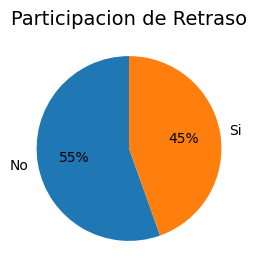

In [13]:
# Retraso: 55% a tiempo, 45% retraso
plt.figure(figsize=(4, 3))
plt.pie(df['Delay'].value_counts(), labels=['No','Si'], autopct='%1.0f%%', startangle=90)
plt.title('Participacion de Retraso', fontsize=14)

plt.show()
# plt.savefig("participacion_target.png", bbox_inches='tight', dpi=300)
# plt.close()

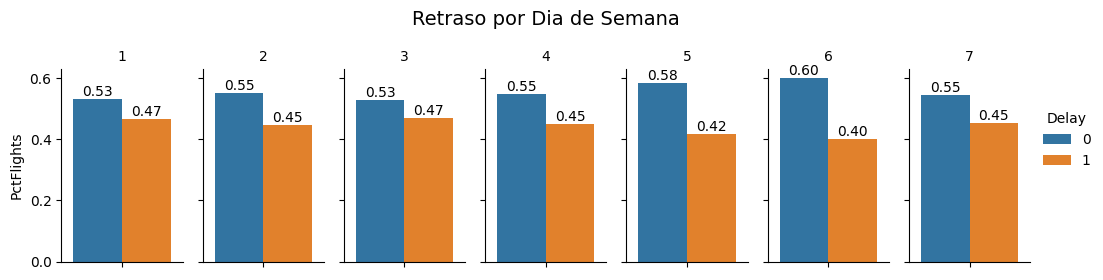

In [14]:
# Retraso por Dia de semana:
# -Dias 5 y 6 tienen menores retrasos
df2 = df.groupby(['DayOfWeek', 'Delay'])['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('DayOfWeek')['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2, hue="Delay", y="PctFlights", col="DayOfWeek",
       kind="bar", height=2.5, aspect=.6
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')


g.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
g.fig.suptitle("Retraso por Dia de Semana", y=1.1, fontsize=14)

plt.show()
# plt.savefig("distribucion_delay_dia_semana.png", bbox_inches='tight', dpi=300)
# plt.close()

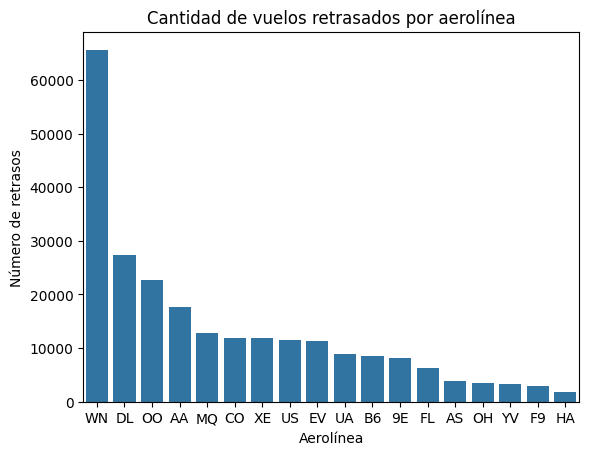

In [15]:
# Cantidad de vuelos retrasados por aerolínea:
order = (
    df[df['Delay']==1].groupby('Airline').size().sort_values(ascending=False).index
)

sns.countplot(data= df[df['Delay']==1], x='Airline', order=order)
plt.title("Cantidad de vuelos retrasados por aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Número de retrasos")
plt.show()

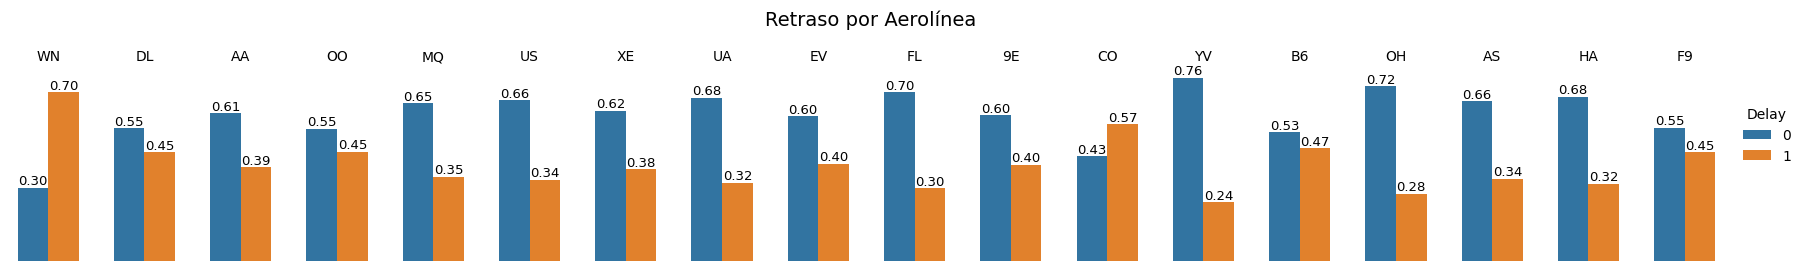

In [16]:
# Retraso por Aerolinea:
# -Solo WN y CO tienen mayor proporcion de retrasos (0.7, 0.57)
df2 = df.groupby(['Airline', 'Delay'])['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('Airline')['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2.sort_values('NumFlights', ascending=False),
       hue="Delay", y="PctFlights", col="Airline",
       kind="bar", height=2.5, aspect=.4
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9.5)

g.set(ylabel=None)
g.set(yticklabels=[])
g.tick_params(left=False, bottom=False)
g.despine(left=True, bottom=True)

g.set_titles(col_template="{col_name}", fontdict={'fontsize': 10.5})
g.fig.suptitle("Retraso por Aerolínea", y=1.1, fontsize=14)

plt.show()
# plt.savefig("distribucion_delay_dia_semana.png", bbox_inches='tight', dpi=300)
# plt.close()

In [17]:
# Verificar variabilidad entre origen-destino
# -CV < 30%: se sugiere datos homogeneos
# -Solo 'GCC-RKS', 'SLC-RKS' tienen variabilidad entre 20-30%
# -Nota: NaN devuelve para casos con solo una observacion
df2 = df.groupby(['AirportFrom', 'AirportTo']).agg(LengthAvg=('Length', 'mean'), LengthStd=('Length', 'std'), LengthCV=('Length', lambda x: x.std()/x.mean())) \
        .reset_index() \
        .sort_values('LengthStd', ascending=False)

In [18]:
df2[df2['LengthCV'] >= 0.3].style.format({'LengthAvg': '{:,.0f}', 'LengthStd': '{:,.1f}', 'LengthCV': '{:.1%}'})

,AirportFrom,AirportTo,LengthAvg,LengthStd,LengthCV


In [19]:
df2[df2['LengthCV'] > 0.2].style.format({'LengthAvg': '{:,.0f}', 'LengthStd': '{:,.1f}', 'LengthCV': '{:.1%}'})

,AirportFrom,AirportTo,LengthAvg,LengthStd,LengthCV
1550,GCC,RKS,90,25.8,28.7%
3902,SLC,RKS,63,13.1,20.9%


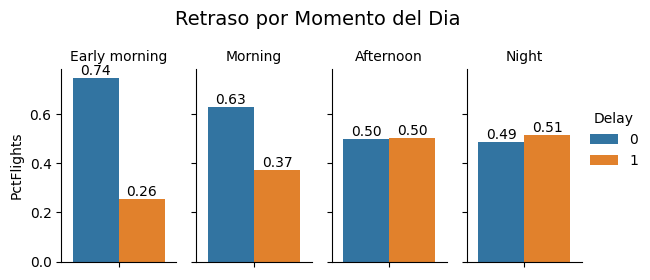

In [20]:
# Retraso por Momento del dia:
# -Los retrasos tienen una alta proporcion (~50%) en la tarde y noche
df2 = df.groupby(['TimeDay', 'Delay'], observed=True)['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('TimeDay', observed=True)['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2, hue="Delay", y="PctFlights", col="TimeDay",
       kind="bar", height=2.5, aspect=.6
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')


g.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
g.fig.suptitle("Retraso por Momento del Dia", y=1.1, fontsize=14)

plt.show()
# plt.savefig("distribucion_delay_momento_dia.png", bbox_inches='tight', dpi=300)
# plt.close()

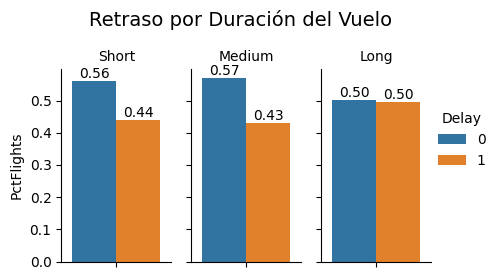

In [21]:
# Retraso por Duración del vuelo:
# -Los retrasos tienen una alta proporcion (~50%) en los vuelos largos
df2 = df.groupby(['Duration', 'Delay'], observed=True)['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('Duration', observed=True)['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2, hue="Delay", y="PctFlights", col="Duration",
       kind="bar", height=2.5, aspect=.6
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')


g.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
g.fig.suptitle("Retraso por Duración del Vuelo", y=1.1, fontsize=14)

plt.show()
# plt.savefig("distribucion_delay_duracion_vuelo.png", bbox_inches='tight', dpi=300)
# plt.close()

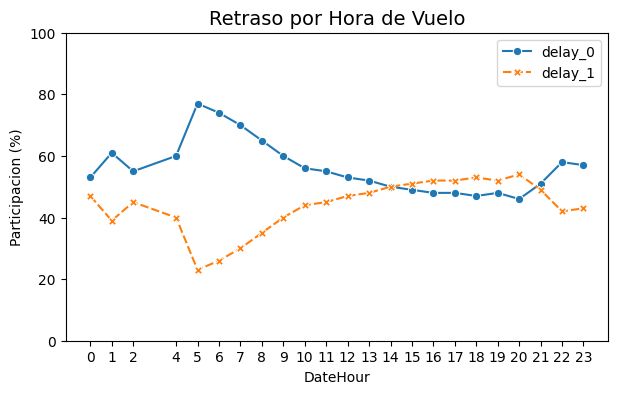

In [66]:
# Retraso por Hora de vuelo
# -Se observa una tendencia creciente a medida que pasa el dia: desde las 5 hasta las 20 horas
df2 = pd.crosstab(df['DateHour'].dt.hour, df['Delay'], normalize='index').round(2) * 100
df2.columns = ['delay_0', 'delay_1']

ax = sns.lineplot(data=df2, markers=True)

ax.set_xticks(df2.index, labels=df2.index)
ax.set_yticks(range(0, 101, 20))
ax.set_ylabel("Participacion (%)")
ax.set_title("Retraso por Hora de Vuelo", fontsize=14, fontweight='normal')
ax.figure.set_size_inches(7, 4)

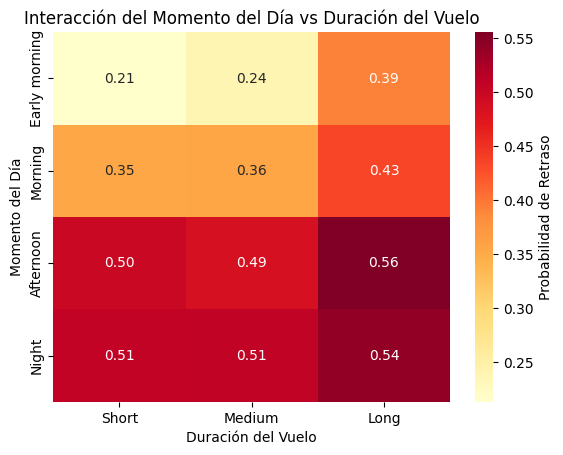

In [68]:
# Heatmap de Momento del Día vs Duración del Vuelo:
timeday_duration = df.pivot_table(
    index='TimeDay', columns='Duration', values='Delay', aggfunc='mean', observed=False
)

sns.heatmap(data=timeday_duration , annot=True, cmap='YlOrRd', fmt=".2f", cbar_kws={'label': 'Probabilidad de Retraso'})
plt.title('Interacción del Momento del Día vs Duración del Vuelo', fontsize=12)
plt.ylabel('Momento del Día')
plt.xlabel('Duración del Vuelo')
plt.show()

### ANALISIS DE CORRELACIONES

In [33]:
# TODO: Correlacion Delay-TimeDay, Delay-Duration
df.sample(5)

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Hour,TimeDay,Duration
162250,UA,169,LGA,ORD,5,657,157,0,1900-01-01 10:57:00,Morning,Medium
523220,XE,5987,ORD,CLE,4,1270,74,1,1900-01-01 21:10:00,Night,Short
272468,OO,6662,MRY,SFO,4,1058,37,0,1900-01-01 17:38:00,Afternoon,Short
117120,UA,212,DEN,IAH,2,1085,143,0,1900-01-01 18:05:00,Night,Medium
314359,EV,5018,ATL,BMI,7,520,115,0,1900-01-01 08:40:00,Morning,Medium
